## Week 2: Tackle Overfitting with Data Augmentation

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import shutil
import random
import os

from tensorflow.keras import layers, losses

In [2]:
from_scratch = False

In [3]:
dataset_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
dataset_file = tf.keras.utils.get_file(origin=dataset_url, extract=True if from_scratch else False)
data_path = pathlib.Path(os.path.join(os.path.dirname(dataset_file), 'PetImages'))

In [4]:
source_path_cats = os.path.join(data_path, 'Cat')
source_path_dogs = os.path.join(data_path, 'Dog')

#### Data cleaning

In [5]:
for file in data_path.glob('*/*.db'):
    os.remove(file)
    print(f'Remove {str(file)}')

In [6]:
def print_num_images():
    print(f'There are {len(os.listdir(source_path_dogs))} images of dogs')
    print(f'There are {len(os.listdir(source_path_cats))} images of cats')

print_num_images()

There are 12494 images of dogs
There are 12497 images of cats


In [7]:
if from_scratch:
    # use script for multiprocessing
    for image_path in data_path.glob('*/*.jpg'):
        try:
            img_bytes = tf.io.read_file(str(image_path))
            tf.io.decode_image(img_bytes)
        except tf.errors.InvalidArgumentError as e:
            print(f'Remove {image_path}')
            os.remove(image_path)

In [8]:
print_num_images()

There are 12494 images of dogs
There are 12497 images of cats


In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    # layers.RandomTranslation(0, 0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip('horizontal')
])

In [10]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    label_mode='binary',
    batch_size=128,
    image_size=(150, 150),
    seed=42,
    validation_split=0.1,
    subset='training'
).cache().prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    label_mode='binary',
    batch_size=32,
    image_size=(150, 150),
    seed=42,
    validation_split=0.1,
    subset='validation'
).cache().prefetch(tf.data.AUTOTUNE)

Found 24991 files belonging to 2 classes.
Using 22492 files for training.
Found 24991 files belonging to 2 classes.
Using 2499 files for validation.


#### Configure the dataset for performance

In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['accuracy'] > 0.8 and logs['val_accuracy'] > 0.8:
            print('\nReached 80% accuracy and validation accuracy so cancelling training')
            self.model.stop_training = True

In [12]:
def create_model():

    model = tf.keras.Sequential([ 
        layers.Rescaling(1/255, input_shape=(150, 150, 3)),
        data_augmentation,
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1)])

    model.compile(optimizer='rmsprop',
                  loss=losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy']) 

    return model

In [13]:
model = create_model()

callbacks = myCallback()

history = model.fit(train_dataset,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_dataset,
                    callbacks=[callbacks])

Epoch 1/15
176/176 [==============================] - 52s 275ms/step - loss: 0.7753 - accuracy: 0.5505 - val_loss: 0.6213 - val_accuracy: 0.5758
Epoch 2/15
176/176 [==============================] - 46s 259ms/step - loss: 0.6044 - accuracy: 0.6481 - val_loss: 0.5230 - val_accuracy: 0.7051
Epoch 3/15
176/176 [==============================] - 44s 252ms/step - loss: 0.5534 - accuracy: 0.6990 - val_loss: 0.6178 - val_accuracy: 0.6439
Epoch 4/15
176/176 [==============================] - 43s 246ms/step - loss: 0.5153 - accuracy: 0.7297 - val_loss: 0.4446 - val_accuracy: 0.7723
Epoch 5/15
176/176 [==============================] - 44s 248ms/step - loss: 0.4867 - accuracy: 0.7499 - val_loss: 0.4405 - val_accuracy: 0.7963
Epoch 6/15
176/176 [==============================] - 43s 247ms/step - loss: 0.4687 - accuracy: 0.7648 - val_loss: 0.4069 - val_accuracy: 0.8107
Epoch 7/15
176/176 [==============================] - 50s 283ms/step - loss: 0.4551 - accuracy: 0.7769 - val_loss: 0.4323 - val_ac

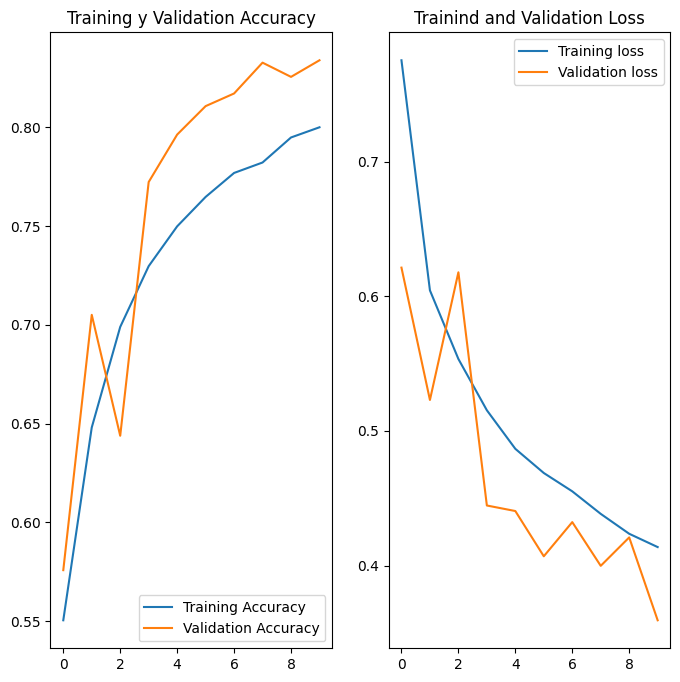

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training y Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Trainind and Validation Loss')
plt.show()